In [ ]:
cd /content/drive/MyDrive/Malicious URL detection

/content/drive/MyDrive/Malicious URL detection


In [ ]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from tld import get_tld, is_tld
import re
from urllib.parse import urlparse
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [ ]:
data = pd.read_csv("malicious_url.csv")

In [ ]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
data.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [ ]:
data["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
data["url_type"] = data["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

In [ ]:
data

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,2
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2


In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)

In [ ]:
data

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2
651188,gamespot.com/xbox360/action/deadspace/,phishing,2
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2


In [ ]:
def get_url_length(url):
    return len(url)

In [ ]:
data['url_len'] = data['url'].apply(lambda x: get_url_length(str(x)))

In [ ]:
data

,url,type,url_type,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45


In [ ]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['pri_domain'] = data['url'].apply(lambda x: extract_pri_domain(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org


In [ ]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [ ]:
data['letters_count'] = data['url'].apply(lambda x: count_letters(x))
data['digits_count']  = data['url'].apply(lambda x: count_digits(x))
data['special_chars_count']  = data['url'].apply(lambda x: count_special_chars(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14
...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9


In [ ]:
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))

In [ ]:
data['shortened']  = data['url'].apply(lambda x: has_shortening_service(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0
...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0


In [ ]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0

In [ ]:
data['abnormal_url']  = data['url'].apply(lambda x: abnormal_url(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1
...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0


In [ ]:
def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0

In [ ]:
data['secure_http']  = data['url'].apply(lambda x: secure_http(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0,0


In [ ]:
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['have_ip']  = data['url'].apply(lambda x: have_ip_address(x))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0,0,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  651191 non-null  object
 1   type                 651191 non-null  object
 2   url_type             651191 non-null  int64 
 3   url_len              651191 non-null  int64 
 4   pri_domain           638968 non-null  object
 5   letters_count        651191 non-null  int64 
 6   digits_count         651191 non-null  int64 
 7   special_chars_count  651191 non-null  int64 
 8   shortened            651191 non-null  int64 
 9   abnormal_url         651191 non-null  int64 
 10  secure_http          651191 non-null  int64 
 11  have_ip              651191 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 59.6+ MB


In [ ]:
data.fillna(0,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  651191 non-null  object
 1   type                 651191 non-null  object
 2   url_type             651191 non-null  int64 
 3   url_len              651191 non-null  int64 
 4   pri_domain           651191 non-null  object
 5   letters_count        651191 non-null  int64 
 6   digits_count         651191 non-null  int64 
 7   special_chars_count  651191 non-null  int64 
 8   shortened            651191 non-null  int64 
 9   abnormal_url         651191 non-null  int64 
 10  secure_http          651191 non-null  int64 
 11  have_ip              651191 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 59.6+ MB


In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x= data['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
)

fig.show()

In [ ]:
type_counts = data['type'].value_counts()
fig = go.Figure(data=[go.Bar(x=type_counts.index, y=type_counts.values)])
fig.update_layout(title='Frequency of URL Types',
                  xaxis_title='URL Type',
                  yaxis_title='Count')
fig.show()

In [ ]:
url_type_counts = data['type'].value_counts()
fig = go.Figure(data=[go.Pie(labels=url_type_counts.index, values=url_type_counts.values)])
fig.update_layout(title='Distribution of URL Types')
fig.show()

In [ ]:
counts = data[['letters_count', 'digits_count', 'special_chars_count']].sum()

# Create a bar chart for the counts of letters, digits, and special characters
fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['letters_count']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['digits_count']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['special_chars_count']])
])

fig.update_layout(title='Counts of Letters, Digits, and Special Characters',
                  xaxis_title='Type',
                  yaxis_title='Count',
                  barmode='group')

fig.show()

In [ ]:
true_color = 'green'

# Define the special color for False count
false_color = 'red'

# Plot bar chart for the 'shortened' column
shortened_counts = data['shortened'].value_counts()
colors = [true_color if val else false_color for val in shortened_counts.index]
fig_shortened = go.Figure(data=go.Bar(x=shortened_counts.index, y=shortened_counts, marker_color=colors))
fig_shortened.update_layout(title='Counts of shortened',
                            xaxis_title='Value',
                            yaxis_title='Count')
fig_shortened.show()

# Plot bar chart for the 'abnormal_url' column
abnormal_url_counts = data['abnormal_url'].value_counts()
colors = [true_color if val else false_color for val in abnormal_url_counts.index]
fig_abnormal_url = go.Figure(data=go.Bar(x=abnormal_url_counts.index, y=abnormal_url_counts, marker_color=colors))
fig_abnormal_url.update_layout(title='Counts of abnormal_url',
                               xaxis_title='Value',
                               yaxis_title='Count')
fig_abnormal_url.show()

# Plot bar chart for the 'secure_http' column
secure_http_counts = data['secure_http'].value_counts()
colors = [true_color if val else false_color for val in secure_http_counts.index]
fig_secure_http = go.Figure(data=go.Bar(x=secure_http_counts.index, y=secure_http_counts, marker_color=colors))
fig_secure_http.update_layout(title='Counts of secure_http',
                              xaxis_title='Value',
                              yaxis_title='Count')
fig_secure_http.show()

# Plot bar chart for the 'have_ip' column
have_ip_counts = data['have_ip'].value_counts()
colors = [true_color if val else false_color for val in have_ip_counts.index]
fig_have_ip = go.Figure(data=go.Bar(x=have_ip_counts.index, y=have_ip_counts, marker_color=colors))
fig_have_ip.update_layout(title='Counts of have_ip',
                          xaxis_title='Value',
                          yaxis_title='Count')
fig_have_ip.show()


<ipython-input-102-c9b662d183c2>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



[]

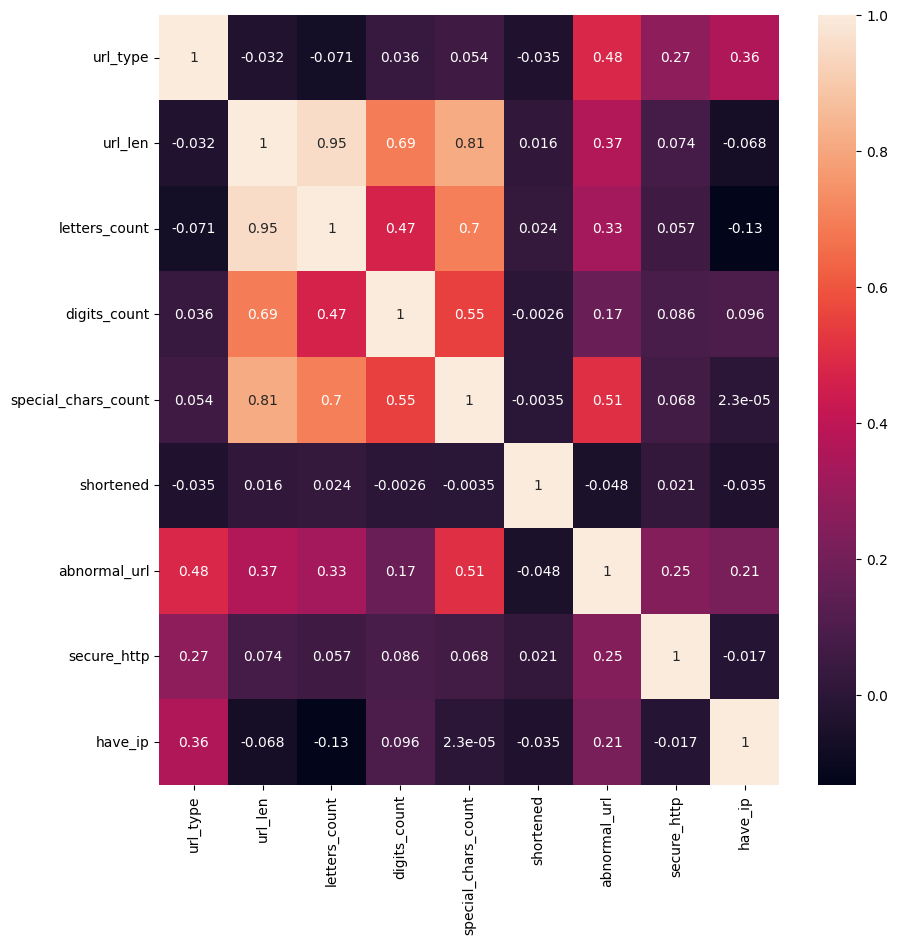

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)
plt.plot()

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0,0,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0,0,0


In [ ]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

In [ ]:
data['url_region'] = data['pri_domain'].apply(lambda x: get_url_region(str(x)))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,Belgium
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0,0,0,Global
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0,0,0,Global
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0,0,0,Global
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0,0,0,Global


In [ ]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [ ]:
data['root_domain'] = data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [ ]:
data

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,21,12,6,0,0,0,0,Global,ign
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,29,7,8,1,0,0,0,Global,teamxbox
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,30,3,5,1,0,0,0,Global,gamespot
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,36,0,9,0,0,0,0,Global,wikipedia


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  651191 non-null  object
 1   type                 651191 non-null  object
 2   url_type             651191 non-null  int64 
 3   url_len              651191 non-null  int64 
 4   pri_domain           651191 non-null  object
 5   letters_count        651191 non-null  int64 
 6   digits_count         651191 non-null  int64 
 7   special_chars_count  651191 non-null  int64 
 8   shortened            651191 non-null  int64 
 9   abnormal_url         651191 non-null  int64 
 10  secure_http          651191 non-null  int64 
 11  have_ip              651191 non-null  int64 
 12  url_region           651191 non-null  object
 13  root_domain          651191 non-null  object
dtypes: int64(9), object(5)
memory usage: 69.6+ MB


In [ ]:
data.duplicated().sum()

11081

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640110 entries, 0 to 651190
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  640110 non-null  object
 1   type                 640110 non-null  object
 2   url_type             640110 non-null  int64 
 3   url_len              640110 non-null  int64 
 4   pri_domain           640110 non-null  object
 5   letters_count        640110 non-null  int64 
 6   digits_count         640110 non-null  int64 
 7   special_chars_count  640110 non-null  int64 
 8   shortened            640110 non-null  int64 
 9   abnormal_url         640110 non-null  int64 
 10  secure_http          640110 non-null  int64 
 11  have_ip              640110 non-null  int64 
 12  url_region           640110 non-null  object
 13  root_domain          640110 non-null  object
dtypes: int64(9), object(5)
memory usage: 73.3+ MB


In [ ]:
data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [ ]:
new_data = data.drop(columns=['url','type','pri_domain'])

In [ ]:
new_data

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,Brazil,br-icloud
1,0,35,29,1,5,0,0,0,0,Global,mp3raid
2,0,31,25,1,5,0,0,0,0,Global,bopsecrets
3,1,84,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,1,235,199,22,14,0,1,0,0,Global,adventure-nicaragua
...,...,...,...,...,...,...,...,...,...,...,...
651186,2,39,21,12,6,0,0,0,0,Global,ign
651187,2,44,29,7,8,1,0,0,0,Global,teamxbox
651188,2,38,30,3,5,1,0,0,0,Global,gamespot
651189,2,45,36,0,9,0,0,0,0,Global,wikipedia


In [ ]:
new_data['root_domain'].value_counts()

wikipedia                  13426
0                          12224
youtube                     8639
blogspot                    8468
facebook                    8362
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: root_domain, Length: 147573, dtype: int64

In [ ]:
new_data = new_data[new_data['root_domain'] != '0']

In [ ]:
new_data['root_domain'].value_counts()

wikipedia                  13426
youtube                     8639
blogspot                    8468
facebook                    8362
yahoo                       5843
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: root_domain, Length: 147572, dtype: int64

In [ ]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [ ]:
new_data['root_domain'] = new_data['root_domain'].apply(hash_encode)

<ipython-input-126-f1918ee6aa70>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
new_data['url_region'] = new_data['url_region'].apply(hash_encode)

<ipython-input-128-22eae43420b7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
new_data

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,27739261,1310791
1,0,35,29,1,5,0,0,0,0,32604616,58335668
2,0,31,25,1,5,0,0,0,0,32604616,28611805
3,1,84,60,7,17,0,1,0,0,71484583,89045308
4,1,235,199,22,14,0,1,0,0,32604616,76838614
...,...,...,...,...,...,...,...,...,...,...,...
651186,2,39,21,12,6,0,0,0,0,32604616,47632402
651187,2,44,29,7,8,1,0,0,0,32604616,33842502
651188,2,38,30,3,5,1,0,0,0,32604616,61429360
651189,2,45,36,0,9,0,0,0,0,32604616,41540124


In [ ]:
x = new_data.drop(columns=['url_type'])
y = new_data['url_type'] 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [ ]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (502308, 10)
Y_train Shape : (502308,)
X_test  Shape : (125578, 10)
Y_test  Shape : (125578,)


In [ ]:
model = DecisionTreeClassifier()

results = []

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
    
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
f1_score = report['macro avg']['f1-score']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
    
results.append({
    'Model': type(model).__name__,
    'Accuracy': accuracy,
    'F1-Score': f1_score,
    'Precision': precision,
    'Recall': recall
    })

print("Test Accuracy: " , accuracy * 100)



Test Accuracy:  89.94170953510965


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     85691
           1       0.94      0.96      0.95     18887
           2       0.68      0.67      0.68     18684
           3       0.78      0.79      0.78      2316

    accuracy                           0.90    125578
   macro avg       0.84      0.84      0.84    125578
weighted avg       0.90      0.90      0.90    125578



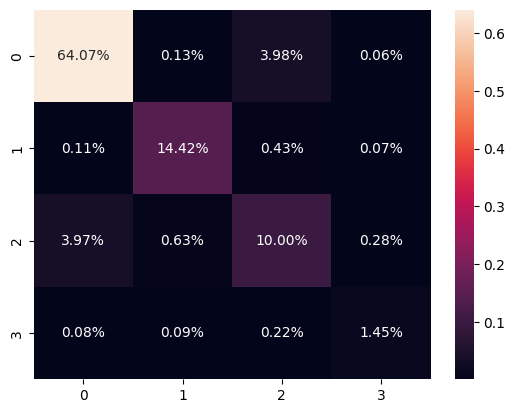

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
plot_ = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='0.2%')
plt.show()